In [ ]:
# B0 - Configuração base (uso LOCAL, sem Google Drive)

from pathlib import Path

# Pasta onde ficam os arquivos da simulação (entradas + saídas do GA).
# Uso a mesma ideia do Data Builder: procuro uma pasta "airnet_inputs" perto do notebook/projeto.
NOTEBOOK_DIR = Path().resolve()
if (NOTEBOOK_DIR / "airnet_inputs").exists():
    BASE_DIR = (NOTEBOOK_DIR / "airnet_inputs").resolve()
else:
    BASE_DIR = (NOTEBOOK_DIR.parent / "airnet_inputs").resolve()

BASE_DIR.mkdir(parents=True, exist_ok=True)

print("Arquivos serão lidos/salvos em:", BASE_DIR)



Mounted at /content/drive
Arquivos vão ser salvos em: /content/drive/MyDrive/airnet_inputs


In [ ]:
# B1 - Imports e leitura dos JSONs gerados pelo QT

import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)

# Usa a BASE_DIR definida no bloco B0
flights_path = BASE_DIR / "flights_ga.json"
assign_path  = BASE_DIR / "passengers_flights.json"

with open(flights_path, "r") as f:
    flights_data = json.load(f)

with open(assign_path, "r") as f:
    assign_data = json.load(f)

# DataFrames base
airports_df = pd.DataFrame(flights_data["airports"])   # id, code, name
flights_df  = pd.DataFrame(flights_data["flights"])    # cada voo
assign_df   = pd.DataFrame(assign_data["assignments"]) # grupos de passageiros

print("Aeroportos:", len(airports_df))
print("Voos      :", len(flights_df))
print("Grupos de passageiros (assignments):", len(assign_df))

display(airports_df.head())
display(flights_df.head())
display(assign_df.head())


Aeroportos: 14
Voos      : 588
Grupos de passageiros (assignments): 523


,code,id,name
0,MA,0,Manaus
1,BE,1,Belém
2,FO,2,Fortaleza
3,NA,3,Natal
4,RE,4,Recife


,aircraft_id,aircraft_idx,arr_hhmm,arr_min,capacity,dep_hhmm,dep_min,dest_id,orig_id,route_id,tmpl_id,used_seats
0,AC_002,2,08:00,480,200,06:00,360,12,9,0,1788,200
1,AC_003,3,10:00,600,200,06:00,360,8,13,0,2462,200
2,AC_004,4,11:00,660,200,06:00,360,0,10,0,1817,200
3,AC_005,5,12:00,720,200,06:00,360,1,13,0,2377,50
4,AC_006,6,09:00,540,200,06:00,360,3,0,0,29,200


,arr_hhmm,arr_min,dep_hhmm,dep_min,dest_id,legs,num_legs,orig_id,pax
0,21:00,1260,19:00,1140,1,"[{'aircraft_idx': 35, 'arr_hhmm': '21:00', 'ar...",1,0,200
1,13:00,780,11:00,660,1,"[{'aircraft_idx': 129, 'arr_hhmm': '13:00', 'a...",1,0,150
2,13:00,780,10:00,600,2,"[{'aircraft_idx': 1, 'arr_hhmm': '13:00', 'arr...",1,0,200
3,09:00,540,06:00,360,3,"[{'aircraft_idx': 6, 'arr_hhmm': '09:00', 'arr...",1,0,200
4,19:00,1140,16:00,960,4,"[{'aircraft_idx': 84, 'arr_hhmm': '19:00', 'ar...",1,0,200


In [3]:
# B2 - Enriquecer voos/passagens e checar totais

# Mapas id -> código / nome de aeroporto
id_to_code = dict(zip(airports_df["id"], airports_df["code"]))
id_to_name = dict(zip(airports_df["id"], airports_df["name"]))

# ---- voos ----
flights_df = flights_df.copy()
flights_df["orig_code"] = flights_df["orig_id"].map(id_to_code)
flights_df["dest_code"] = flights_df["dest_id"].map(id_to_code)
flights_df["orig_name"] = flights_df["orig_id"].map(id_to_name)
flights_df["dest_name"] = flights_df["dest_id"].map(id_to_name)

flights_df["duration_min"] = flights_df["arr_min"] - flights_df["dep_min"]
flights_df["route_str"] = flights_df["orig_code"] + "->" + flights_df["dest_code"]
flights_df["dep_hour"] = (flights_df["dep_min"] // 60).astype(int)
flights_df["arr_hour"] = (flights_df["arr_min"] // 60).astype(int)

# ocupar assentos por voo a partir de passengers_flights.json
from collections import Counter

pax_per_flight = Counter()
for row in assign_data["assignments"]:
    pax = row["pax"]
    for leg in row["legs"]:
        pax_per_flight[leg["flight_index"]] += pax

flights_df["pax"] = flights_df.index.map(lambda i: pax_per_flight.get(int(i), 0))
flights_df["load_factor"] = flights_df["pax"] / flights_df["capacity"]

# ---- passageiros (grupos) ----
assign_df = assign_df.copy()
assign_df["orig_code"] = assign_df["orig_id"].map(id_to_code)
assign_df["dest_code"] = assign_df["dest_id"].map(id_to_code)
assign_df["route_str"] = assign_df["orig_code"] + "->" + assign_df["dest_code"]

assign_df["travel_time_min"] = assign_df["arr_min"] - assign_df["dep_min"]

served_total = int(assign_df["pax"].sum())
direct_total = int(assign_df.loc[assign_df["num_legs"] == 1, "pax"].sum())
onehop_total = int(assign_df.loc[assign_df["num_legs"] == 2, "pax"].sum())
multihop_total = int(assign_df.loc[assign_df["num_legs"] >= 3, "pax"].sum())

print("====== RESUMO PASSAGEIROS (reconstruído) ======")
print("Served total:", served_total)
print("  diretos   :", direct_total)
print("  1 conexão :", onehop_total)
print("  2+ conex. :", multihop_total)

print("\n====== RESUMO VOOS ======")
print("Voos ativos    :", len(flights_df))
print("Aeronaves usas :", flights_df["aircraft_id"].nunique())

display(flights_df.head(10))


====== RESUMO PASSAGEIROS (reconstruído) ======
Served total: 94800
  diretos   : 90500
  1 conexão : 4300
  2+ conex. : 0

====== RESUMO VOOS ======
Voos ativos    : 588
Aeronaves usas : 233


,aircraft_id,aircraft_idx,arr_hhmm,arr_min,capacity,dep_hhmm,dep_min,dest_id,orig_id,route_id,...,orig_code,dest_code,orig_name,dest_name,duration_min,route_str,dep_hour,arr_hour,pax,load_factor
0,AC_002,2,08:00,480,200,06:00,360,12,9,0,...,RJ,FL,Rio de Janeiro,Florianópolis,120,RJ->FL,6,8,200,1.00
1,AC_003,3,10:00,600,200,06:00,360,8,13,0,...,PA,CI,Porto Alegre,Cuiabá,240,PA->CI,6,10,200,1.00
2,AC_004,4,11:00,660,200,06:00,360,0,10,0,...,SP,MA,São Paulo,Manaus,300,SP->MA,6,11,200,1.00
3,AC_005,5,12:00,720,200,06:00,360,1,13,0,...,PA,BE,Porto Alegre,Belém,360,PA->BE,6,12,50,0.25
4,AC_006,6,09:00,540,200,06:00,360,3,0,0,...,MA,NA,Manaus,Natal,180,MA->NA,6,9,200,1.00
5,AC_007,7,07:00,420,200,06:00,360,10,9,0,...,RJ,SP,Rio de Janeiro,São Paulo,60,RJ->SP,6,7,200,1.00
6,AC_009,9,07:00,420,200,06:00,360,12,13,0,...,PA,FL,Porto Alegre,Florianópolis,60,PA->FL,6,7,200,1.00
7,AC_010,10,07:00,420,200,06:00,360,7,9,0,...,RJ,BH,Rio de Janeiro,Belo Horizonte,60,RJ->BH,6,7,200,1.00
8,AC_012,12,09:00,540,200,06:00,360,4,9,0,...,RJ,RE,Rio de Janeiro,Recife,180,RJ->RE,6,9,200,1.00
9,AC_015,15,08:00,480,200,06:00,360,5,10,0,...,SP,SA,São Paulo,Salvador,120,SP->SA,6,8,200,1.00


In [4]:
# B3 - TAB_AV: Alocação de Voos (vooVVVV)

# Dar um ID textual pro voo: V0001, V0002, ...
flights_df = flights_df.copy()
flights_df["flight_id"] = ["V{:04d}".format(i) for i in range(1, len(flights_df) + 1)]

tab_av = flights_df[[
    "flight_id",
    "aircraft_id",
    "orig_code", "dest_code",
    "dep_hhmm", "arr_hhmm",
    "dep_min", "arr_min",
    "pax", "capacity", "load_factor",
    "duration_min", "route_str"
]].sort_values(["dep_min", "orig_code", "dest_code"]).reset_index(drop=True)

print("TAB_AV (primeiras linhas):")
display(tab_av.head(20))

# Se quiser salvar:
tab_av_path = BASE_DIR / "TAB_AV_voos.csv"
tab_av.to_csv(tab_av_path, index=False)
print("Salvo TAB_AV em:", tab_av_path)


TAB_AV (primeiras linhas):


,flight_id,aircraft_id,orig_code,dest_code,dep_hhmm,arr_hhmm,dep_min,arr_min,pax,capacity,load_factor,duration_min,route_str
0,V0013,AC_026,BH,FL,06:00,08:00,360,480,200,200,1.00,120,BH->FL
1,V0016,AC_030,BH,RE,06:00,09:00,360,540,200,200,1.00,180,BH->RE
2,V0018,AC_032,BR,CR,06:00,09:00,360,540,200,200,1.00,180,BR->CR
3,V0020,AC_037,BR,RE,06:00,09:00,360,540,200,200,1.00,180,BR->RE
4,V0019,AC_034,CR,BE,06:00,11:00,360,660,200,200,1.00,300,CR->BE
5,V0029,AC_070,CR,SP,06:00,07:00,360,420,200,200,1.00,60,CR->SP
6,V0023,AC_046,FO,PA,06:00,12:00,360,720,200,200,1.00,360,FO->PA
7,V0005,AC_006,MA,NA,06:00,09:00,360,540,200,200,1.00,180,MA->NA
8,V0014,AC_027,MA,SP,06:00,11:00,360,660,200,200,1.00,300,MA->SP
9,V0024,AC_047,NA,BE,06:00,08:00,360,480,200,200,1.00,120,NA->BE


Salvo TAB_AV em: /content/drive/MyDrive/airnet_inputs/TAB_AV_voos.csv


In [5]:
# B4 - TAB_AP: Alocação de passageiros (por grupo de itinerário)

# Converter lista de legs em string "V0001|V0123|..."
flight_index_to_id = dict(zip(flights_df.index, flights_df["flight_id"]))

def legs_to_str(legs):
    ids = [ flight_index_to_id.get(leg["flight_index"], f"IDX{leg['flight_index']}")
            for leg in legs ]
    return " | ".join(ids)

tab_ap = pd.DataFrame({
    "group_id": np.arange(len(assign_df), dtype=int),
    "orig_code": assign_df["orig_code"],
    "dest_code": assign_df["dest_code"],
    "route_str": assign_df["route_str"],
    "pax": assign_df["pax"],
    "num_legs": assign_df["num_legs"],
    "dep_hhmm": assign_df["dep_hhmm"],
    "arr_hhmm": assign_df["arr_hhmm"],
    "travel_time_min": assign_df["travel_time_min"],
    "voos": assign_df["legs"].apply(legs_to_str)
})

print("TAB_AP (primeiras linhas):")
display(tab_ap.head(20))

tab_ap_path = BASE_DIR / "TAB_AP_passageiros_grupos.csv"
tab_ap.to_csv(tab_ap_path, index=False)
print("Salvo TAB_AP em:", tab_ap_path)

# Algumas estatísticas de distribuição
print("\nDistribuição de número de pernas (grupos):")
display(tab_ap.groupby("num_legs")["pax"].sum().to_frame("pax_total"))


TAB_AP (primeiras linhas):


,group_id,orig_code,dest_code,route_str,pax,num_legs,dep_hhmm,arr_hhmm,travel_time_min,voos
0,0,MA,BE,MA->BE,200,1,19:00,21:00,120,V0551
1,1,MA,BE,MA->BE,150,1,11:00,13:00,120,V0257
2,2,MA,FO,MA->FO,200,1,10:00,13:00,180,V0194
3,3,MA,NA,MA->NA,200,1,06:00,09:00,180,V0005
4,4,MA,RE,MA->RE,200,1,16:00,19:00,180,V0470
5,5,MA,RE,MA->RE,50,2,11:00,16:00,300,V0257 | V0405
6,6,MA,RE,MA->RE,50,2,12:00,18:00,360,V0289 | V0518
7,7,MA,SA,MA->SA,200,1,12:00,15:00,180,V0306
8,8,MA,BR,MA->BR,200,1,08:00,11:00,180,V0094
9,9,MA,BR,MA->BR,200,1,11:00,14:00,180,V0239


Salvo TAB_AP em: /content/drive/MyDrive/airnet_inputs/TAB_AP_passageiros_grupos.csv

Distribuição de número de pernas (grupos):


,pax_total
num_legs,
1,90500
2,4300


Plano diário (texto) para as 5 primeiras aeronaves:

=== AC_000 ===
  V0501: PA->BH 17:00–20:00 (100 pax, LF=0.50)

=== AC_001 ===
  V0194: MA->FO 10:00–13:00 (200 pax, LF=1.00)
  V0409: FO->BE 14:00–16:00 (200 pax, LF=1.00)

=== AC_002 ===
  V0001: RJ->FL 06:00–08:00 (200 pax, LF=1.00)
  V0166: FL->FO 09:00–14:00 (0 pax, LF=0.00)
  V0427: FO->NA 15:00–16:00 (200 pax, LF=1.00)
  V0515: NA->FO 17:00–18:00 (0 pax, LF=0.00)
  V0561: FO->BH 19:00–22:00 (100 pax, LF=0.50)

=== AC_003 ===
  V0002: PA->CI 06:00–10:00 (200 pax, LF=1.00)
  V0255: CI->BR 11:00–12:00 (200 pax, LF=1.00)
  V0369: BR->BH 13:00–14:00 (200 pax, LF=1.00)

=== AC_004 ===
  V0003: SP->MA 06:00–11:00 (200 pax, LF=1.00)
  V0289: MA->FO 12:00–15:00 (50 pax, LF=0.25)


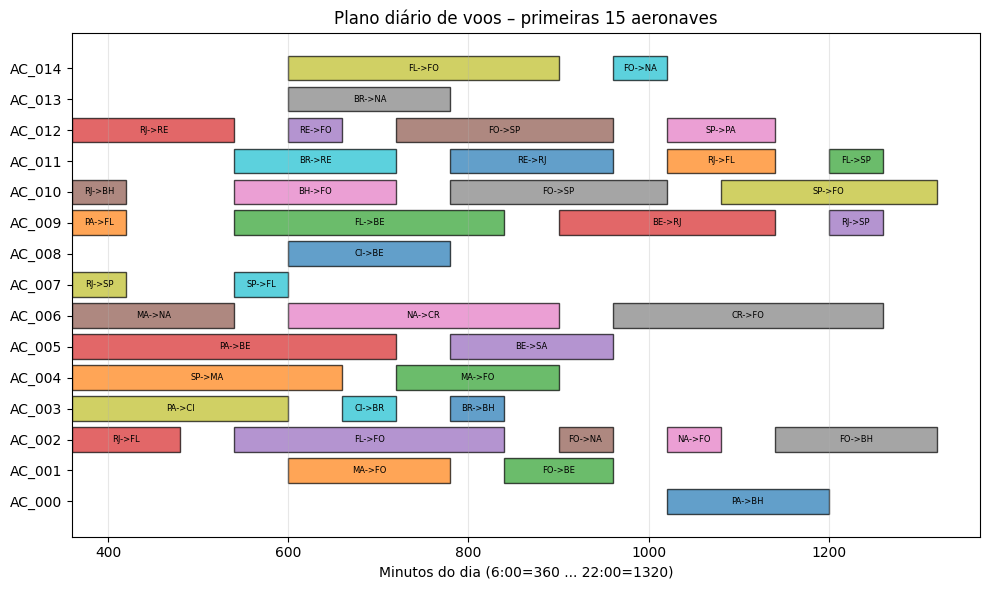

In [6]:
# B5 - TAB_PV: plano diário por aeronave (texto + gráfico tipo Gantt)

# Tabela: para cada aeronave, lista de voos em ordem temporal
tab_pv = flights_df.sort_values(["aircraft_id", "dep_min"])

print("Plano diário (texto) para as 5 primeiras aeronaves:")
for ac_id, group in tab_pv.groupby("aircraft_id"):
    print(f"\n=== {ac_id} ===")
    for _, row in group.iterrows():
        print(f"  {row['flight_id']}: {row['orig_code']}->{row['dest_code']} "
              f"{row['dep_hhmm']}–{row['arr_hhmm']} "
              f"({row['pax']} pax, LF={row['load_factor']:.2f})")
    # limita para não explodir
    if int(ac_id.split("_")[1]) >= 4:
        break

# Gantt simplificado (exibir só primeiras N aeronaves pra ficar legível)
N_AC_TO_PLOT = 15
sub = tab_pv[tab_pv["aircraft_id"].isin(
    sorted(tab_pv["aircraft_id"].unique())[:N_AC_TO_PLOT]
)]

ac_list = sorted(sub["aircraft_id"].unique())
ac_to_y = {ac: i for i, ac in enumerate(ac_list)}

plt.figure(figsize=(10, 6))
for _, row in sub.iterrows():
    y = ac_to_y[row["aircraft_id"]]
    plt.barh(
        y,
        width=row["duration_min"],
        left=row["dep_min"],
        align="center",
        edgecolor="k",
        alpha=0.7,
    )
    plt.text(
        row["dep_min"] + row["duration_min"]/2,
        y,
        row["route_str"],
        ha="center",
        va="center",
        fontsize=6,
    )

plt.yticks(range(len(ac_list)), ac_list)
plt.xlabel("Minutos do dia (6:00=360 ... 22:00=1320)")
plt.title(f"Plano diário de voos – primeiras {N_AC_TO_PLOT} aeronaves")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


Plano diário (texto) para as 5 primeiras aeronaves:

=== AC_000 ===
  V0501: PA->BH 17:00–20:00 (100 pax, LF=0.50)

=== AC_001 ===
  V0194: MA->FO 10:00–13:00 (200 pax, LF=1.00)
  V0409: FO->BE 14:00–16:00 (200 pax, LF=1.00)

=== AC_002 ===
  V0001: RJ->FL 06:00–08:00 (200 pax, LF=1.00)
  V0166: FL->FO 09:00–14:00 (0 pax, LF=0.00)
  V0427: FO->NA 15:00–16:00 (200 pax, LF=1.00)
  V0515: NA->FO 17:00–18:00 (0 pax, LF=0.00)
  V0561: FO->BH 19:00–22:00 (100 pax, LF=0.50)

=== AC_003 ===
  V0002: PA->CI 06:00–10:00 (200 pax, LF=1.00)
  V0255: CI->BR 11:00–12:00 (200 pax, LF=1.00)
  V0369: BR->BH 13:00–14:00 (200 pax, LF=1.00)

=== AC_004 ===
  V0003: SP->MA 06:00–11:00 (200 pax, LF=1.00)
  V0289: MA->FO 12:00–15:00 (50 pax, LF=0.25)


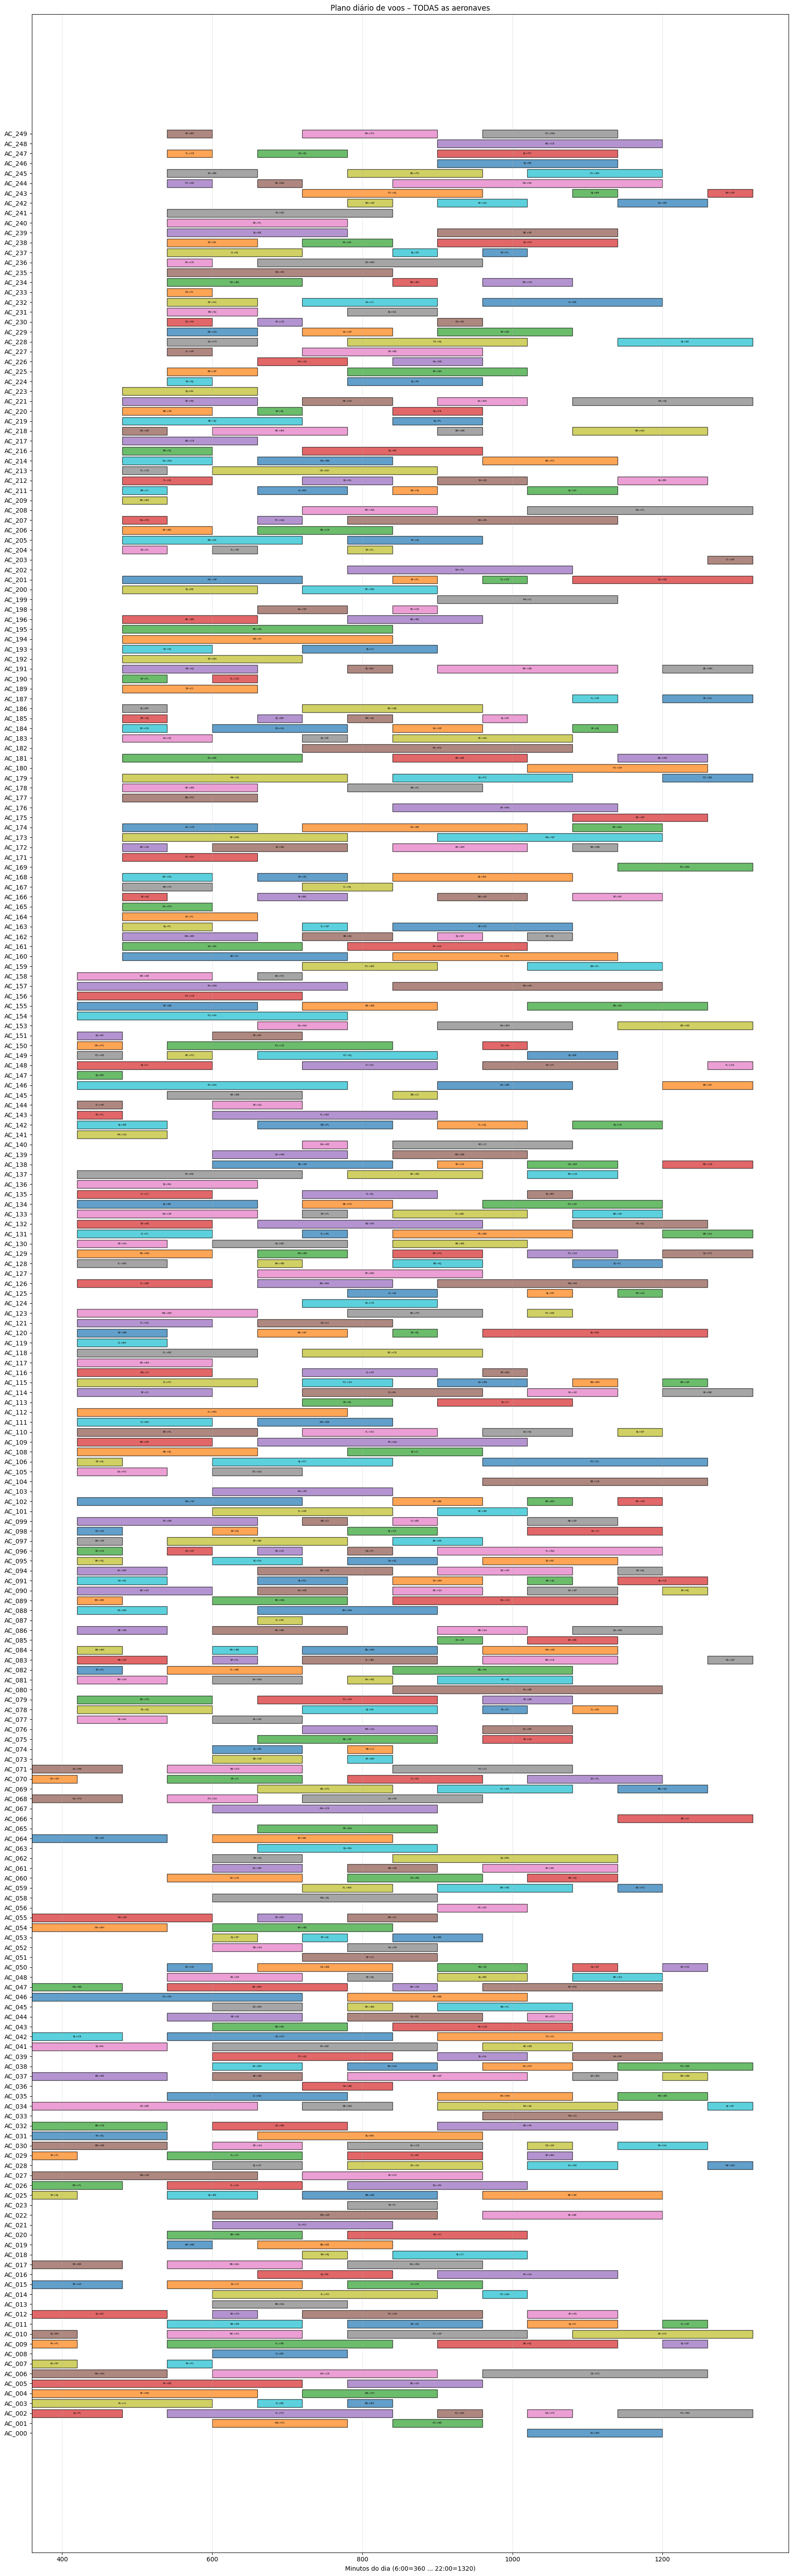

In [7]:
# B5 - TAB_PV: plano diário por aeronave (texto + gráfico tipo Gantt - TODAS AS AERONAVES)

# Tabela: para cada aeronave, lista de voos em ordem temporal
tab_pv = flights_df.sort_values(["aircraft_id", "dep_min"])

print("Plano diário (texto) para as 5 primeiras aeronaves:")
for ac_id, group in tab_pv.groupby("aircraft_id"):
    print(f"\n=== {ac_id} ===")
    for _, row in group.iterrows():
        print(
            f"  {row['flight_id']}: {row['orig_code']}->{row['dest_code']} "
            f"{row['dep_hhmm']}–{row['arr_hhmm']} "
            f"({row['pax']} pax, LF={row['load_factor']:.2f})"
        )
    # limita só o texto pra não virar novela
    if int(ac_id.split("_")[1]) >= 4:
        break

# Gantt com TODAS as aeronaves
ac_list = sorted(tab_pv["aircraft_id"].unique())
ac_to_y = {ac: i for i, ac in enumerate(ac_list)}

# Altura proporcional ao número de aeronaves
height = max(8, 0.25 * len(ac_list))   # ajusta se quiser mais alto/baixo
plt.figure(figsize=(18, height))

for _, row in tab_pv.iterrows():
    y = ac_to_y[row["aircraft_id"]]
    plt.barh(
        y,
        width=row["duration_min"],
        left=row["dep_min"],
        align="center",
        edgecolor="k",
        alpha=0.7,
    )
    # rótulo pequeno pra caber mais coisa
    plt.text(
        row["dep_min"] + row["duration_min"] / 2,
        y,
        row["route_str"],
        ha="center",
        va="center",
        fontsize=4,
    )

plt.yticks(range(len(ac_list)), ac_list)
plt.xlabel("Minutos do dia (6:00=360 ... 22:00=1320)")
plt.title("Plano diário de voos – TODAS as aeronaves")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


Plano diário (texto) para as 5 primeiras aeronaves:

=== AC_000 ===
  V0501: PA->BH 17:00–20:00 (100 pax, LF=0.50)

=== AC_001 ===
  V0194: MA->FO 10:00–13:00 (200 pax, LF=1.00)
  V0409: FO->BE 14:00–16:00 (200 pax, LF=1.00)

=== AC_002 ===
  V0001: RJ->FL 06:00–08:00 (200 pax, LF=1.00)
  V0166: FL->FO 09:00–14:00 (0 pax, LF=0.00)
  V0427: FO->NA 15:00–16:00 (200 pax, LF=1.00)
  V0515: NA->FO 17:00–18:00 (0 pax, LF=0.00)
  V0561: FO->BH 19:00–22:00 (100 pax, LF=0.50)

=== AC_003 ===
  V0002: PA->CI 06:00–10:00 (200 pax, LF=1.00)
  V0255: CI->BR 11:00–12:00 (200 pax, LF=1.00)
  V0369: BR->BH 13:00–14:00 (200 pax, LF=1.00)

=== AC_004 ===
  V0003: SP->MA 06:00–11:00 (200 pax, LF=1.00)
  V0289: MA->FO 12:00–15:00 (50 pax, LF=0.25)


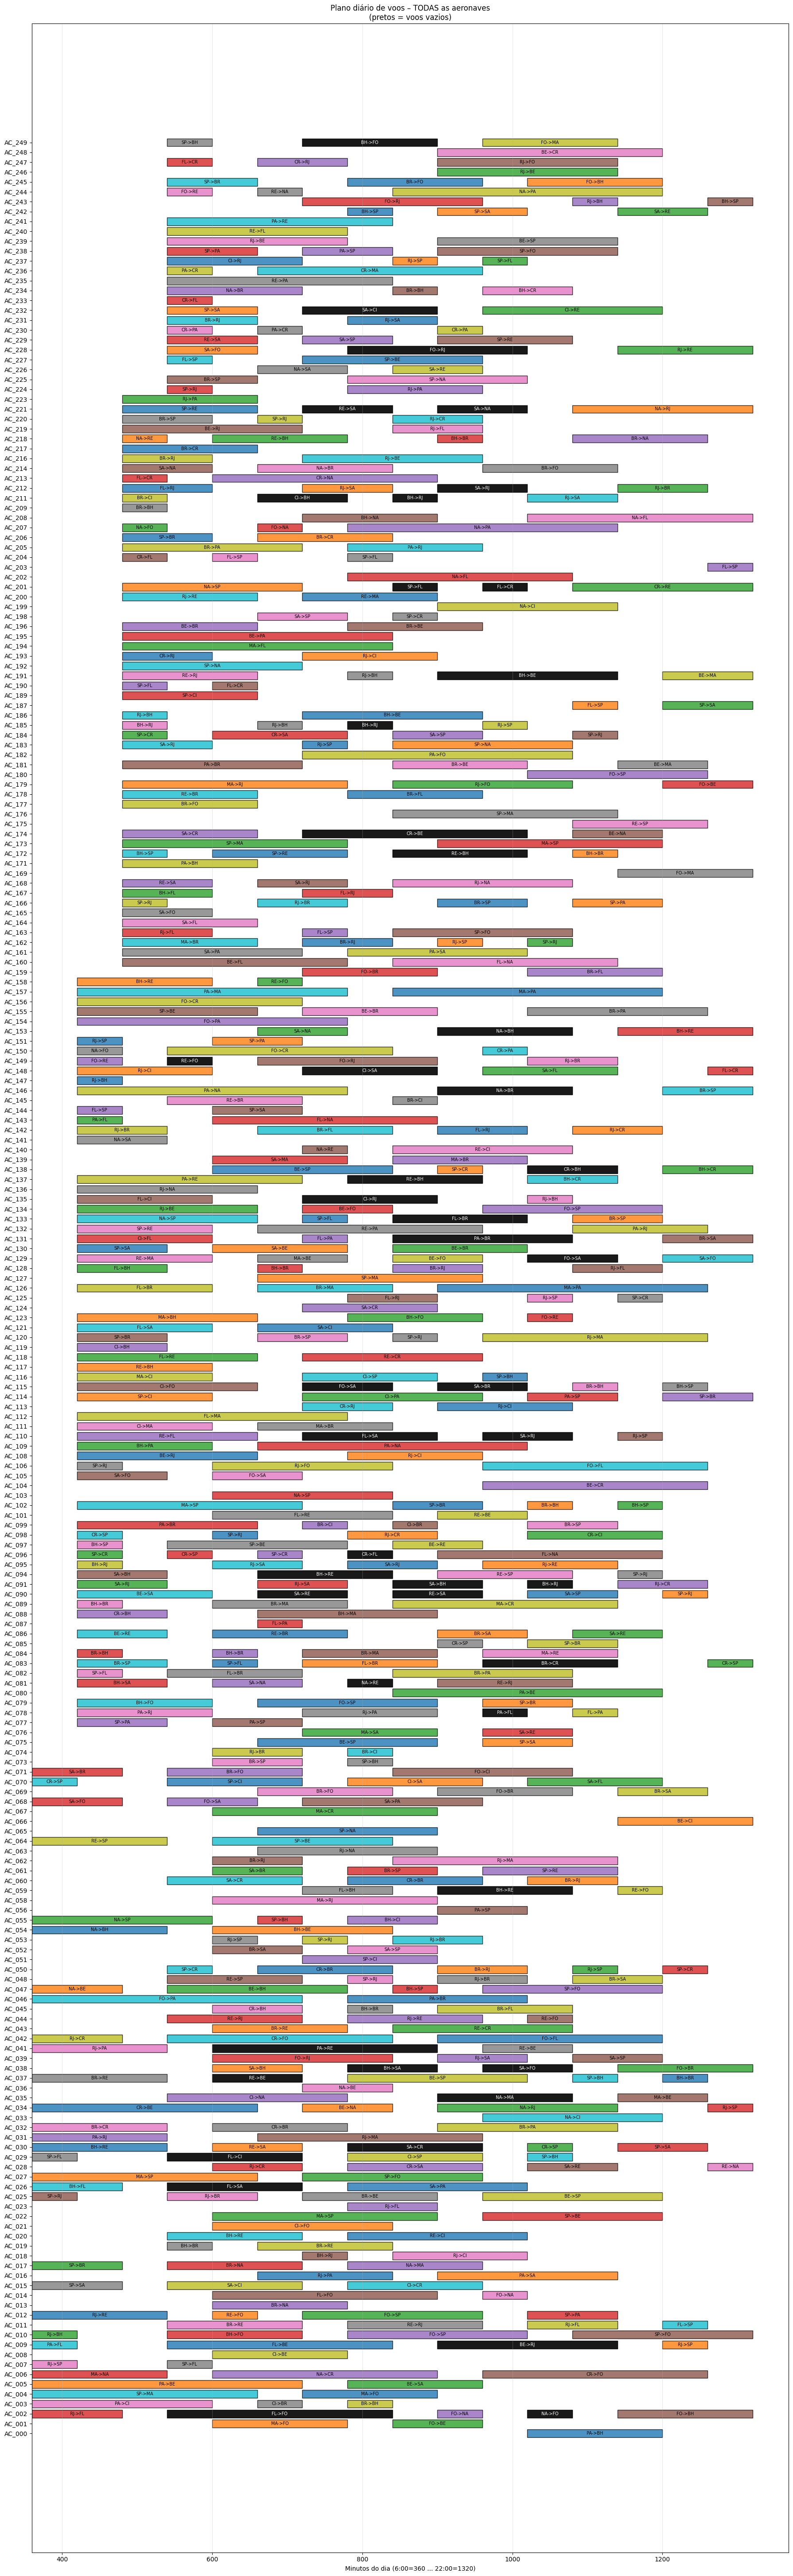

In [8]:
# B5 - TAB_PV: plano diário por aeronave (texto + gráfico tipo Gantt - TODAS AS AERONAVES)

# Tabela: para cada aeronave, lista de voos em ordem temporal
tab_pv = flights_df.sort_values(["aircraft_id", "dep_min"])

print("Plano diário (texto) para as 5 primeiras aeronaves:")
for ac_id, group in tab_pv.groupby("aircraft_id"):
    print(f"\n=== {ac_id} ===")
    for _, row in group.iterrows():
        print(
            f"  {row['flight_id']}: {row['orig_code']}->{row['dest_code']} "
            f"{row['dep_hhmm']}–{row['arr_hhmm']} "
            f"({row['pax']} pax, LF={row['load_factor']:.2f})"
        )
    # limita só o texto pra não virar novela
    if int(ac_id.split("_")[1]) >= 4:
        break

# -------- Gantt com TODAS as aeronaves --------

ac_list = sorted(tab_pv["aircraft_id"].unique())
ac_to_y = {ac: i for i, ac in enumerate(ac_list)}

# Altura proporcional ao número de aeronaves
height = max(8, 0.25 * len(ac_list))   # ajusta se quiser mais alto/baixo
plt.figure(figsize=(18, height))

for _, row in tab_pv.iterrows():
    y = ac_to_y[row["aircraft_id"]]
    dur = row["duration_min"]
    start = row["dep_min"]
    label = row["route_str"]

    # trata pax NaN como 0
    pax = row.get("pax", 0)
    if pd.isna(pax):
        pax = 0

    # Voos vazios: bloco preto + texto branco
    is_empty = (pax <= 0)

    if is_empty:
        # barra preta
        plt.barh(
            y,
            width=dur,
            left=start,
            align="center",
            edgecolor="k",
            alpha=0.9,
            color="black",
        )
        txt_color = "white"
    else:
        # usa cor default do Matplotlib
        plt.barh(
            y,
            width=dur,
            left=start,
            align="center",
            edgecolor="k",
            alpha=0.8,
        )
        txt_color = "black"

    # rótulo maior pra ficar legível
    plt.text(
        start + dur / 2,
        y,
        label,
        ha="center",
        va="center",
        fontsize=7,   # aumenta aqui se quiser ainda maior
        color=txt_color,
    )

plt.yticks(range(len(ac_list)), ac_list)
plt.xlabel("Minutos do dia (6:00=360 ... 22:00=1320)")
plt.title("Plano diário de voos – TODAS as aeronaves\n(pretos = voos vazios)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# B6 - TAB_MV: mapa de voos (contagem de voos por Orig, Dest, horário)

# apenas voos válidos (orig != dest)
mv_base = flights_df[flights_df["orig_id"] != flights_df["dest_id"]].copy()
mv_base["hour"] = mv_base["dep_min"] // 60  # 6..21

hours = list(range(6, 22))  # 06..21

mv = (
    mv_base
    .groupby(["orig_code", "dest_code", "hour"])
    .size()
    .reset_index(name="num_flights")
)

for orig in airports_df["code"]:
    tmp = mv[mv["orig_code"] == orig]
    if tmp.empty:
        continue

    piv = tmp.pivot_table(
        index="dest_code",
        columns="hour",
        values="num_flights",
        fill_value=0
    )

    # garante todas as horas como colunas, na ordem certa
    piv = piv.reindex(columns=hours, fill_value=0).sort_index()

    # só pra garantir tipo inteiro bonitinho
    piv = piv.astype(int)

    print(f"\n=== TAB_MV - Origem {orig} ===")
    display(piv)



=== TAB_MV - Origem MA ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
BH,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BR,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
CI,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CR,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
FL,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
FO,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
NA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PA,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0



=== TAB_MV - Origem BE ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BH,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
BR,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
CI,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
CR,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
FL,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
FO,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
MA,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
NA,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
PA,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0



=== TAB_MV - Origem FO ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
BH,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
BR,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
CI,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
CR,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
FL,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
MA,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
NA,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0
PA,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



=== TAB_MV - Origem NA ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
BH,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
BR,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
CI,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
CR,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
FL,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
FO,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
MA,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
PA,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0



=== TAB_MV - Origem RE ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
BH,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
BR,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
CI,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
CR,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
FL,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
FO,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0
MA,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1



=== TAB_MV - Origem SA ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
BH,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
BR,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
CI,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
CR,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0
FL,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
FO,1,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0
MA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
NA,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0



=== TAB_MV - Origem BR ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
BH,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,0
CI,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0
CR,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
FL,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0
FO,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0
MA,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
NA,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
PA,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0



=== TAB_MV - Origem BH ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
BR,0,1,0,1,1,1,0,1,0,1,0,0,1,0,1,0
CI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
CR,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
FL,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
FO,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0
MA,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
PA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



=== TAB_MV - Origem CI ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
BH,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
BR,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
CR,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
FL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FO,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
MA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
PA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0



=== TAB_MV - Origem RJ ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0
BH,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,0
BR,0,1,0,1,1,1,0,0,1,1,0,1,0,1,0,0
CI,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0
CR,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0
FL,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0
FO,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
MA,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
NA,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0



=== TAB_MV - Origem SP ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0
BH,0,0,0,1,0,1,0,1,0,0,1,1,1,0,0,0
BR,1,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0
CI,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0
CR,0,1,1,1,0,1,0,0,1,1,0,0,0,1,1,0
FL,1,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0
FO,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0
MA,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
NA,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0



=== TAB_MV - Origem CR ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
BH,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
BR,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
CI,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
FL,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
FO,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
MA,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
PA,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0



=== TAB_MV - Origem FL ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
BH,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
BR,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0
CI,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
CR,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1
FO,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
MA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
PA,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0



=== TAB_MV - Origem PA ===


hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
dest_code,,,,,,,,,,,,,,,,
BE,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
BH,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
BR,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0
CI,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CR,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
FL,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
FO,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
MA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


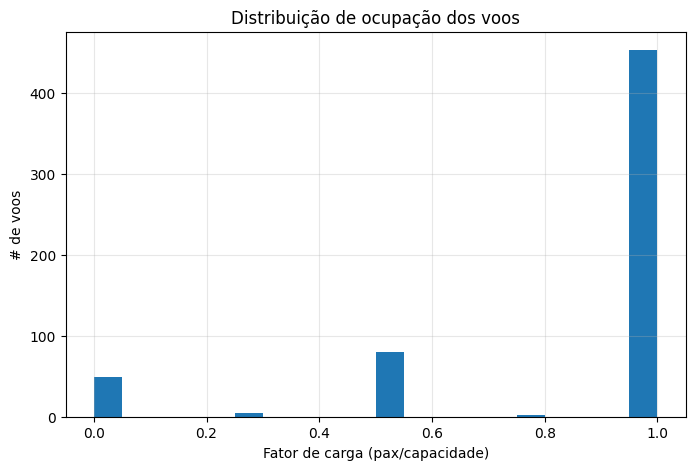

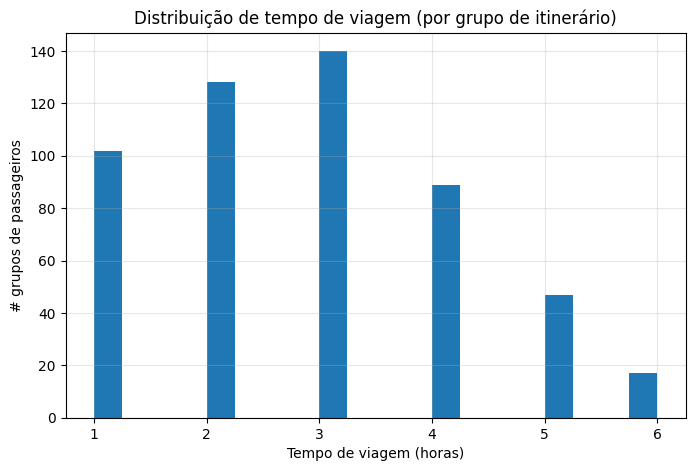

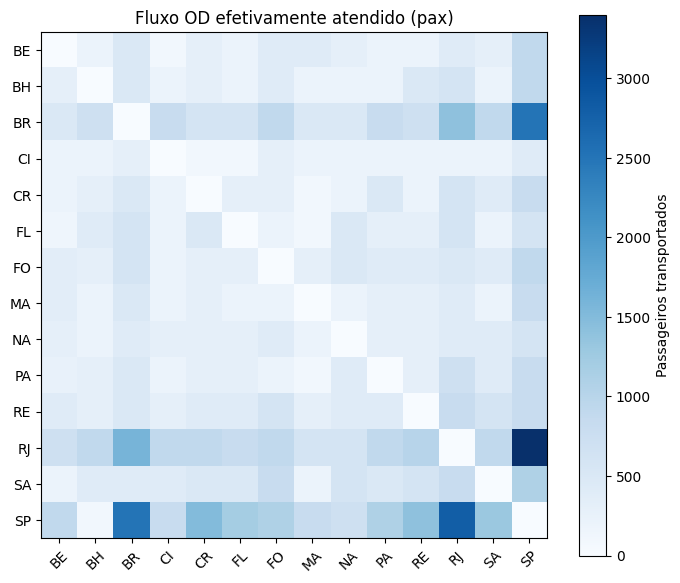

In [10]:
# B7 - Mais gráficos: load factor, distribuição de tempo de viagem, matriz OD servida

# 1) Histograma de ocupação dos voos
plt.figure()
plt.hist(flights_df["load_factor"], bins=20)
plt.xlabel("Fator de carga (pax/capacidade)")
plt.ylabel("# de voos")
plt.title("Distribuição de ocupação dos voos")
plt.grid(alpha=0.3)
plt.show()

# 2) Histograma de tempo de viagem dos grupos de passageiros
plt.figure()
plt.hist(assign_df["travel_time_min"]/60.0, bins=20)
plt.xlabel("Tempo de viagem (horas)")
plt.ylabel("# grupos de passageiros")
plt.title("Distribuição de tempo de viagem (por grupo de itinerário)")
plt.grid(alpha=0.3)
plt.show()

# 3) Heatmap OD servida (pax efetivamente transportados)
od_served = (
    assign_df
    .groupby(["orig_code", "dest_code"])["pax"]
    .sum()
    .reset_index()
)

piv_od = od_served.pivot_table(
    index="orig_code",
    columns="dest_code",
    values="pax",
    fill_value=0
).sort_index(axis=0).sort_index(axis=1)

plt.figure(figsize=(7, 6))
plt.imshow(piv_od.values, cmap="Blues")
plt.colorbar(label="Passageiros transportados")
plt.xticks(range(len(piv_od.columns)), piv_od.columns, rotation=45)
plt.yticks(range(len(piv_od.index)), piv_od.index)
plt.title("Fluxo OD efetivamente atendido (pax)")
plt.tight_layout()
plt.show()


In [11]:
# === Bloco: Relatório completo em PDF (flights_ga.json + passengers_flights.json) ===

import json
import math
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ----------------------------------------------------------------------
# 1) Carrega dados
# ----------------------------------------------------------------------

# Usa a mesma BASE_DIR do data builder
FLIGHTS_JSON = BASE_DIR / "flights_ga.json"
PAX_JSON     = BASE_DIR / "passengers_flights.json"
OUTPUT_PDF   = BASE_DIR / "relatorio_trafego_aereo.pdf"

print("Lendo:", FLIGHTS_JSON)
print("Lendo:", PAX_JSON)

with open(FLIGHTS_JSON, "r") as f:
    flights_data = json.load(f)

with open(PAX_JSON, "r") as f:
    pax_data = json.load(f)

summary = flights_data.get("summary", {})
flights_df = pd.DataFrame(flights_data.get("flights", []))
assign_df  = pd.DataFrame(pax_data.get("assignments", []))

# Códigos de aeroportos (ordem do enunciado)
airport_codes = ["MA","BE","FO","NA","RE","SA","BR","BH","CI","RJ","SP","CR","FL","PA"]
id_to_code = {i: code for i, code in enumerate(airport_codes)}

# mapeia IDs numéricos para códigos
if "orig_id" in flights_df.columns:
    flights_df["orig_code"] = flights_df["orig_id"].map(id_to_code)
    flights_df["dest_code"] = flights_df["dest_id"].map(id_to_code)

if "orig_id" in assign_df.columns:
    assign_df["orig_code"] = assign_df["orig_id"].map(id_to_code)
    assign_df["dest_code"] = assign_df["dest_id"].map(id_to_code)

# Horários em horas (para gráficos)
def min_to_hour(m):
    return m / 60.0

if "dep_min" in flights_df.columns:
    flights_df["dep_hour"] = flights_df["dep_min"].apply(min_to_hour)
if "arr_min" in flights_df.columns:
    flights_df["arr_hour"] = flights_df["arr_min"].apply(min_to_hour)

if "dep_min" in assign_df.columns:
    assign_df["dep_hour"] = assign_df["dep_min"].apply(min_to_hour)
if "arr_min" in assign_df.columns:
    assign_df["arr_hour"] = assign_df["arr_min"].apply(min_to_hour)

# ----------------------------------------------------------------------
# 2) Métricas derivadas
# ----------------------------------------------------------------------

# Ocupação dos voos (se existir used_seats / capacity)
if "used_seats" in flights_df.columns and "capacity" in flights_df.columns:
    flights_df["load_factor"] = flights_df["used_seats"] / flights_df["capacity"]
else:
    flights_df["load_factor"] = np.nan

# Quantidade de passageiros servidos por OD (a partir de assign_df)
if "pax" in assign_df.columns:
    od_pax = (
        assign_df
        .groupby(["orig_code", "dest_code"], as_index=False)["pax"]
        .sum()
        .rename(columns={"pax": "pax_served"})
    )
else:
    od_pax = pd.DataFrame(columns=["orig_code","dest_code","pax_served"])

# Quantidade de voos por OD
od_flights = (
    flights_df
    .groupby(["orig_code","dest_code"], as_index=False)
    .size()
    .rename(columns={"size":"num_flights"})
)

# Junta info de OD
od_summary = pd.merge(od_flights, od_pax, on=["orig_code","dest_code"], how="outer")
od_summary["num_flights"] = od_summary["num_flights"].fillna(0).astype(int)
od_summary["pax_served"]  = od_summary["pax_served"].fillna(0).astype(int)

# Top 10 rotas por passageiros servidos
top_routes = od_summary.sort_values("pax_served", ascending=False).head(10)

# Totais a partir do summary do GA (para garantir consistência)
served_total   = summary.get("served_total", 0)
served_direct  = summary.get("served_direct", 0)
served_1hop    = summary.get("served_1hop", 0)
unserved       = summary.get("unserved", 0)
flights_used   = summary.get("flights_used", len(flights_df))
aircraft_used  = summary.get(
    "aircraft_used",
    flights_df["aircraft_idx"].nunique() if "aircraft_idx" in flights_df else None
)
total_time_min = summary.get("total_travel_time_min_pax", 0)

total_demand = served_total + unserved if served_total or unserved else None

# ----------------------------------------------------------------------
# 3) Geração do PDF
# ----------------------------------------------------------------------

with PdfPages(OUTPUT_PDF) as pdf:

    # ----------------------------------------------------------
    # Página 1 - Resumo Geral
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4 retrato
    ax.axis("off")

    lines = []
    lines.append("Planejamento de Rotas - Tráfego Aéreo Brasileiro")
    lines.append("")
    lines.append("Resumo geral da solução do GA\n")
    if total_demand is not None:
        lines.append(f"Demanda total estimada (TAB_OD): {total_demand:,.0f} passageiros")
    lines.append(f"Passageiros atendidos: {served_total:,.0f}")
    lines.append(f"  - Voos diretos: {served_direct:,.0f}")
    lines.append(f"  - Com 1 conexão: {served_1hop:,.0f}")
    lines.append(f"Passageiros não atendidos: {unserved:,.0f}")
    if total_demand:
        perc_served   = 100.0 * served_total / total_demand
        perc_unserved = 100.0 * unserved / total_demand
        lines.append(f"Percentual atendido: {perc_served:.2f}%")
        lines.append(f"Percentual não atendido: {perc_unserved:.2f}%")
    lines.append("")
    lines.append(f"Número de voos planejados: {flights_used}")
    if aircraft_used is not None:
        lines.append(f"Aeronaves utilizadas: {aircraft_used} (capacidade 200 assentos cada)")
    lines.append("")
    lines.append(f"Tempo total de viagem (min * passageiro): {total_time_min:,.0f}")
    if served_total > 0:
        avg_time = total_time_min / served_total
        lines.append(f"Tempo médio de viagem por passageiro atendido: {avg_time:.1f} min")
    lines.append("")
    lines.append("Observação: estes números são resultado do melhor indivíduo da última geração do GA.")

    ax.text(
        0.02, 0.98,
        "\n".join(lines),
        va="top",
        ha="left",
        fontsize=11,
        wrap=True
    )

    pdf.savefig(fig)
    plt.close(fig)

    # ----------------------------------------------------------
    # Página 2 - Distribuição de voos por horário de partida
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # A4 paisagem

    if "dep_hour" in flights_df.columns:
        bins = np.arange(6, 23)  # 6..22
        ax.hist(flights_df["dep_hour"], bins=bins, edgecolor="black")
        ax.set_xlabel("Hora de partida")
        ax.set_ylabel("Quantidade de voos")
        ax.set_title("Distribuição de voos por horário de partida")
        ax.set_xticks(bins)
    else:
        ax.text(0.5, 0.5, "Sem informação de horário de partida (dep_min).",
                ha="center", va="center")
    pdf.savefig(fig)
    plt.close(fig)

    # ----------------------------------------------------------
    # Página 3 - Voos por aeroporto (partidas e chegadas)
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(11.69, 8.27))

    dep_counts = flights_df["orig_code"].value_counts().reindex(airport_codes, fill_value=0)
    arr_counts = flights_df["dest_code"].value_counts().reindex(airport_codes, fill_value=0)

    x = np.arange(len(airport_codes))
    width = 0.35

    ax.bar(x - width/2, dep_counts.values, width, label="Partidas")
    ax.bar(x + width/2, arr_counts.values, width, label="Chegadas")

    ax.set_xticks(x)
    ax.set_xticklabels(airport_codes)
    ax.set_xlabel("Aeroporto")
    ax.set_ylabel("Número de voos")
    ax.set_title("Partidas e chegadas por aeroporto")
    ax.legend()

    pdf.savefig(fig)
    plt.close(fig)

    # ----------------------------------------------------------
    # Página 4 - Ocupação dos voos (load factor)
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(11.69, 8.27))

    if "load_factor" in flights_df.columns and flights_df["load_factor"].notna().any():
        ax.hist(flights_df["load_factor"].dropna(), bins=20, edgecolor="black")
        ax.set_xlabel("Fator de carga (used_seats / capacity)")
        ax.set_ylabel("Quantidade de voos")
        ax.set_title("Distribuição do fator de carga dos voos")
    else:
        ax.text(0.5, 0.5, "Sem dados de used_seats/capacity para calcular load factor.",
                ha="center", va="center")

    pdf.savefig(fig)
    plt.close(fig)

    # ----------------------------------------------------------
    # Página 5 - Matriz de voos por par Origem-Destino
    # ----------------------------------------------------------
    flights_matrix = pd.DataFrame(0, index=airport_codes, columns=airport_codes, dtype=int)
    for _, row in od_summary.iterrows():
        o = row["orig_code"]
        d = row["dest_code"]
        if pd.isna(o) or pd.isna(d):
            continue
        flights_matrix.at[o, d] = int(row["num_flights"])

    fig, ax = plt.subplots(figsize=(8.27, 11.69))
    im = ax.imshow(flights_matrix.values, aspect="auto")

    ax.set_xticks(np.arange(len(airport_codes)))
    ax.set_xticklabels(airport_codes, rotation=90)
    ax.set_yticks(np.arange(len(airport_codes)))
    ax.set_yticklabels(airport_codes)

    ax.set_xlabel("Destino")
    ax.set_ylabel("Origem")
    ax.set_title("Número de voos por par Origem-Destino")

    for i in range(len(airport_codes)):
        for j in range(len(airport_codes)):
            val = flights_matrix.values[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha="center", va="center", fontsize=7)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Voos")
    pdf.savefig(fig)
    plt.close(fig)

    # ----------------------------------------------------------
    # Página 6 - Matriz de passageiros servidos por OD
    # ----------------------------------------------------------
    pax_matrix = pd.DataFrame(0, index=airport_codes, columns=airport_codes, dtype=int)
    for _, row in od_summary.iterrows():
        o = row["orig_code"]
        d = row["dest_code"]
        if pd.isna(o) or pd.isna(d):
            continue
        pax_matrix.at[o, d] = int(row["pax_served"])

    fig, ax = plt.subplots(figsize=(8.27, 11.69))
    im = ax.imshow(pax_matrix.values, aspect="auto")

    ax.set_xticks(np.arange(len(airport_codes)))
    ax.set_xticklabels(airport_codes, rotation=90)
    ax.set_yticks(np.arange(len(airport_codes)))
    ax.set_yticklabels(airport_codes)

    ax.set_xlabel("Destino")
    ax.set_ylabel("Origem")
    ax.set_title("Passageiros servidos por par Origem-Destino")

    for i in range(len(airport_codes)):
        for j in range(len(airport_codes)):
            val = pax_matrix.values[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha="center", va="center", fontsize=6)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Passageiros")
    pdf.savefig(fig)
    plt.close(fig)

    # ----------------------------------------------------------
    # Página 7 - Top 10 rotas por passageiros servidos (tabela)
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(11.69, 8.27))
    ax.axis("off")

    ax.set_title("Top 10 rotas por passageiros servidos", fontsize=14, pad=20)

    if not top_routes.empty:
        tbl = top_routes.copy()
        tbl = tbl[["orig_code","dest_code","num_flights","pax_served"]]
        tbl.columns = ["Origem","Destino","Voos","Passageiros servidos"]

        table = ax.table(
            cellText=tbl.values,
            colLabels=tbl.columns,
            loc="center"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
    else:
        ax.text(0.5, 0.5, "Sem dados de rotas.",
                ha="center", va="center")

    pdf.savefig(fig)
    plt.close(fig)

print(f"PDF gerado em: {OUTPUT_PDF}")


Lendo: /content/drive/MyDrive/airnet_inputs/flights_ga.json
Lendo: /content/drive/MyDrive/airnet_inputs/passengers_flights.json
PDF gerado em: /content/drive/MyDrive/airnet_inputs/relatorio_trafego_aereo.pdf


In [12]:
# B8 - Evolução do GA (carregar ga_stats.json)

import json

ga_stats_path = BASE_DIR / "ga_stats.json"
print("Lendo:", ga_stats_path)

with open(ga_stats_path, "r") as f:
    ga_stats = json.load(f)

# DataFrame com uma linha por geração
evo_df = pd.DataFrame(ga_stats["evolution"])

print("Gerações:", evo_df["generation"].min(), "->", evo_df["generation"].max())
display(evo_df.head())


Lendo: /content/drive/MyDrive/airnet_inputs/ga_stats.json
Gerações: 0 -> 100


,avg_score,best_score,duration_ms,generation,num_flights,served_1hop,served_direct,served_total,unserved,used_aircraft,worst_score
0,-3516144000,-1000000000,236,0,0,0,0,0,0,0,-3956700000
1,-2925306300,-1000000000,353,1,0,0,0,0,0,0,-3302430000
2,-2352675300,-1000000000,441,2,0,0,0,0,0,0,-2794680000
3,-1775071800,-1000000000,566,3,0,0,0,0,0,0,-2286720000
4,-1202748900,-649950000,886,4,175,6850,20900,27750,67050,175,-1657200000


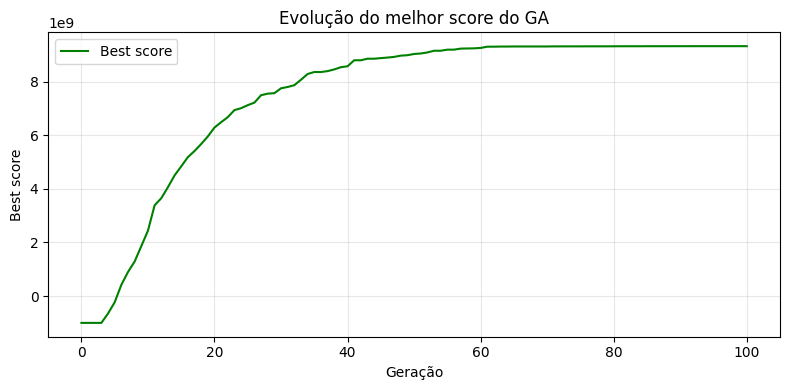

In [13]:
# B8.1 - Curva do melhor score por geração

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["best_score"], label="Best score", color="green")
plt.xlabel("Geração")
plt.ylabel("Best score")
plt.title("Evolução do melhor score do GA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


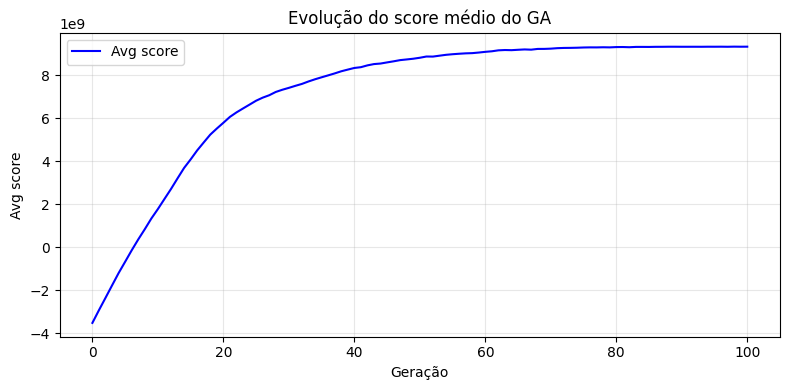

In [14]:
# B8.2 - Curva do score médio por geração

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["avg_score"], label="Avg score", color="blue")
plt.xlabel("Geração")
plt.ylabel("Avg score")
plt.title("Evolução do score médio do GA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


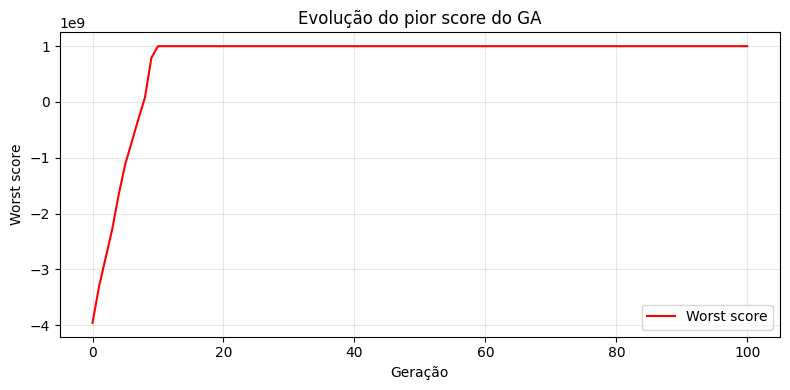

In [15]:
# B8.3 - Curva do pior score por geração

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["worst_score"], label="Worst score", color="red")
plt.xlabel("Geração")
plt.ylabel("Worst score")
plt.title("Evolução do pior score do GA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


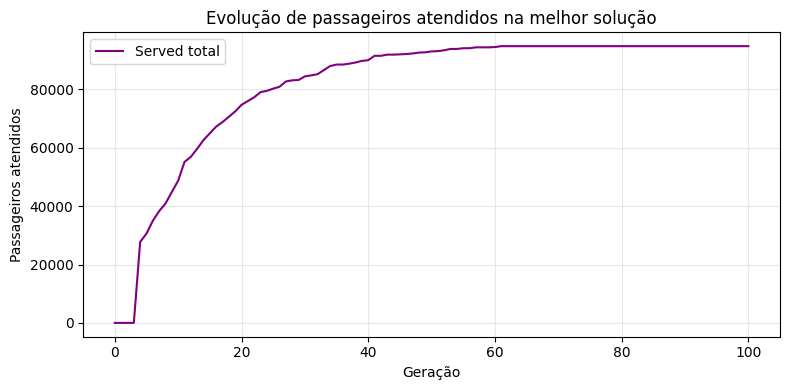

In [16]:
# B8.4 - Passageiros atendidos (melhor indivíduo de cada geração)

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["served_total"], label="Served total", color="purple")
plt.xlabel("Geração")
plt.ylabel("Passageiros atendidos")
plt.title("Evolução de passageiros atendidos na melhor solução")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


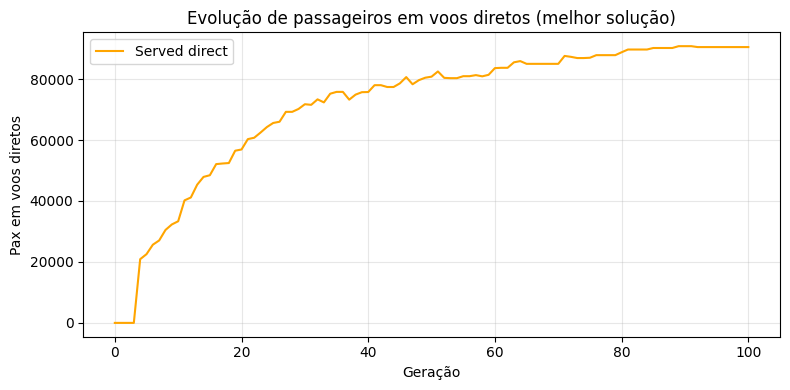

In [17]:
# B8.5 - Passageiros em voos diretos (melhor indivíduo de cada geração)

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["served_direct"], label="Served direct", color="orange")
plt.xlabel("Geração")
plt.ylabel("Pax em voos diretos")
plt.title("Evolução de passageiros em voos diretos (melhor solução)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


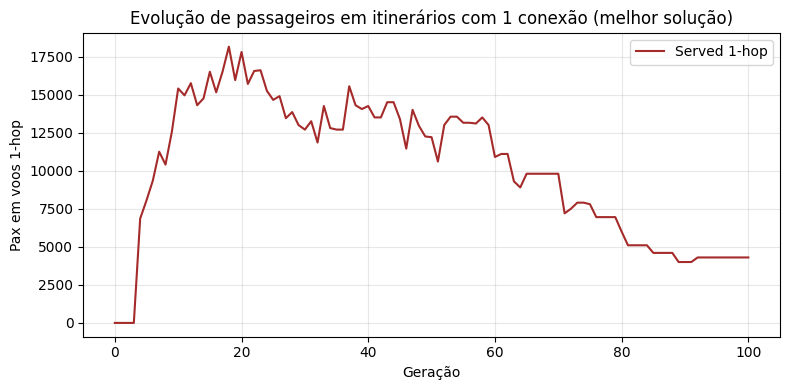

In [18]:
# B8.6 - Passageiros em voos 1-hop (1 conexão) na melhor solução por geração

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["served_1hop"], label="Served 1-hop", color="brown")
plt.xlabel("Geração")
plt.ylabel("Pax em voos 1-hop")
plt.title("Evolução de passageiros em itinerários com 1 conexão (melhor solução)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


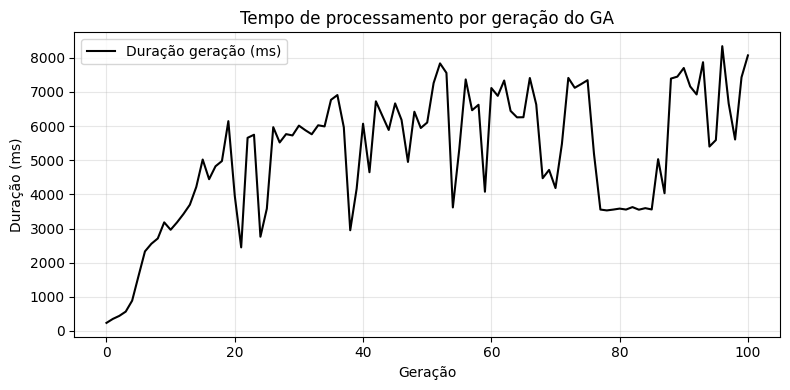

In [19]:
# B8.7 - Tempo por geração (milissegundos por geração)

plt.figure(figsize=(8, 4))
plt.plot(evo_df["generation"], evo_df["duration_ms"], label="Duração geração (ms)", color="black")
plt.xlabel("Geração")
plt.ylabel("Duração (ms)")
plt.title("Tempo de processamento por geração do GA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Lendo airports geométrico: /content/drive/MyDrive/airnet_inputs/airports.json


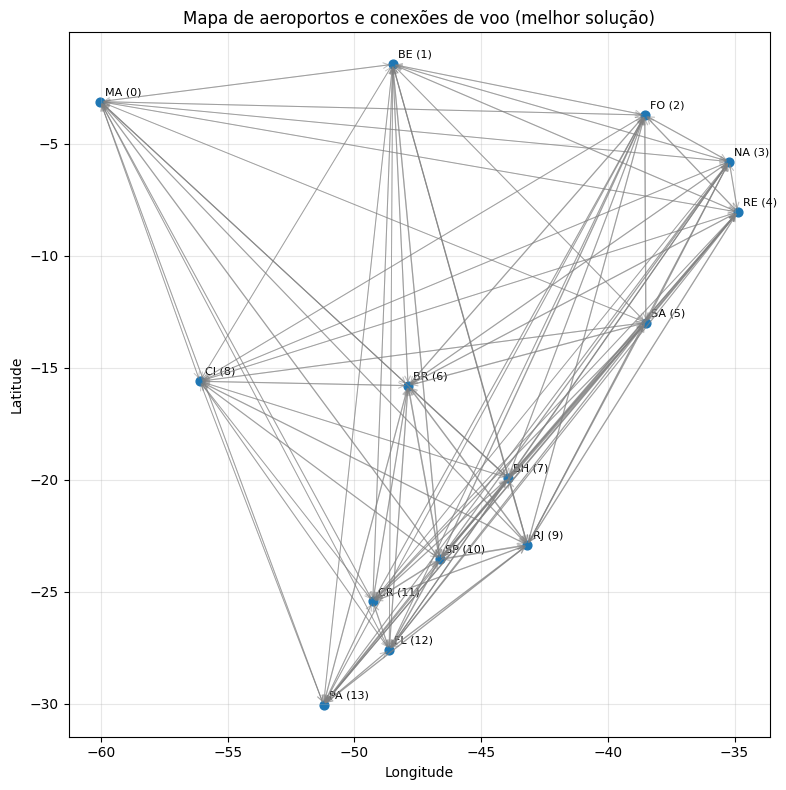

In [20]:
# B9 - Mapa dos aeroportos (lat/lon de airports.json) e setas de voos

# Carrega airports.json original (com lat/lon)
airports_json_path = BASE_DIR / "airports.json"
print("Lendo airports geométrico:", airports_json_path)

with open(airports_json_path, "r") as f:
    airports_geo = json.load(f)

airports_geo_df = pd.DataFrame(airports_geo["airports"])  # id, code, name, lat, lon

# Junta com flights_df para saber quais pares OD têm voos
edges = (
    flights_df
    .groupby(["orig_id", "dest_id"], as_index=False)
    .size()
    .rename(columns={"size": "num_flights"})
)

id_to_lat = dict(zip(airports_geo_df["id"], airports_geo_df["lat"]))
id_to_lon = dict(zip(airports_geo_df["id"], airports_geo_df["lon"]))
id_to_code = dict(zip(airports_geo_df["id"], airports_geo_df["code"]))

plt.figure(figsize=(8, 8))

# Plota pontos dos aeroportos
for _, row in airports_geo_df.iterrows():
    x = row["lon"]
    y = row["lat"]
    plt.scatter(x, y, s=40, color="tab:blue")
    plt.text(
        x + 0.2,
        y + 0.2,
        f"{row['code']} ({row['id']})",
        fontsize=8,
        ha="left",
        va="bottom",
    )

# Plota setas para cada par OD com voos
for _, row in edges.iterrows():
    o = row["orig_id"]
    d = row["dest_id"]
    if o == d:
        continue
    x_o, y_o = id_to_lon[o], id_to_lat[o]
    x_d, y_d = id_to_lon[d], id_to_lat[d]

    # largura da linha proporcional ao número de voos
    lw = 0.5 + 0.5 * math.log10(row["num_flights"] + 1)

    plt.annotate(
        "",
        xy=(x_d, y_d),
        xytext=(x_o, y_o),
        arrowprops=dict(arrowstyle="->", color="gray", alpha=0.5, linewidth=lw),
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mapa de aeroportos e conexões de voo (melhor solução)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Tentando usar mapa: /content/drive/MyDrive/airnet_inputs/Brazil_states_blank.png
OK - imagem carregada: /content/drive/MyDrive/airnet_inputs/Brazil_states_blank.png


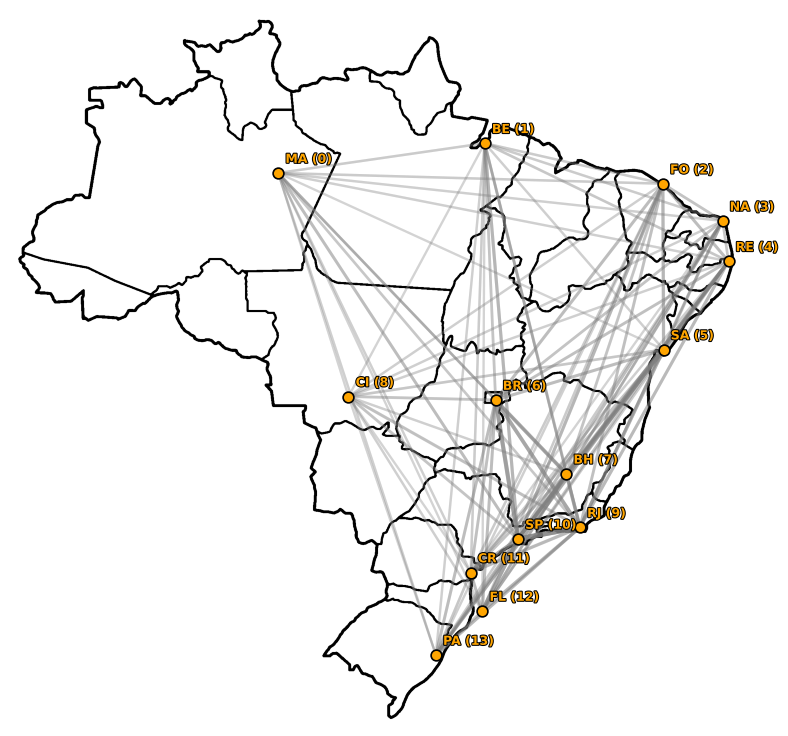

In [22]:
# B9c - Mapa do Brasil (imagem local) + aeroportos e setas (sem eixos)

import matplotlib.image as mpimg
import matplotlib.patheffects as pe

# tenta ler uma versão PNG (recomendada) ou SVG do mapa no BASE_DIR
map_path_png = BASE_DIR / "Brazil_states_blank.png"
map_path_svg = BASE_DIR / "Brazil_Blank_Map.svg"

img = None
for p in [map_path_png, map_path_svg]:
    if p.exists():
        print("Tentando usar mapa:", p)
        try:
            img = mpimg.imread(str(p))
            print("OK - imagem carregada:", p)
            break
        except Exception as e:
            print("Falha ao ler", p, "->", e)

if img is None:
    print("Nao foi possivel carregar nenhuma imagem de mapa (PNG ou SVG).")

# Limites geográficos medidos no mapa (lon/lat aproximados)
left_lon   = -75
right_lon  = -34
top_lat    = 6
bottom_lat = -34

# extent = [xmin, xmax, ymin, ymax]
extent = [left_lon, right_lon, bottom_lat, top_lat]

fig, ax = plt.subplots(figsize=(8, 8))

if img is not None:
    ax.imshow(img, extent=extent, origin="upper", alpha=1.0)

# Garante que temos os DataFrames necessários
if 'airports_geo_df' not in globals():
    airports_json_path = BASE_DIR / "airports.json"
    with open(airports_json_path, "r") as f:
        airports_geo = json.load(f)
    airports_geo_df = pd.DataFrame(airports_geo["airports"])

if 'edges' not in globals():
    edges = (
        flights_df
        .groupby(["orig_id", "dest_id"], as_index=False)
        .size()
        .rename(columns={"size": "num_flights"})
    )

# Carrega pares proibidos de forbidden_routes.json (se existir)
forbidden_pairs = []
forb_path = BASE_DIR / "forbidden_routes.json"
try:
    if forb_path.exists():
        with open(forb_path, "r") as f:
            forb_data = json.load(f)
        for v in forb_data.get("forbidden_od", []):
            o = v.get("orig_id")
            d = v.get("dest_id")
            if o is not None and d is not None:
                forbidden_pairs.append((int(o), int(d)))
    else:
        print("Aviso: forbidden_routes.json nao encontrado em", forb_path)
except Exception as e:
    print("Erro lendo forbidden_routes.json:", e)

id_to_lat = dict(zip(airports_geo_df["id"], airports_geo_df["lat"]))
id_to_lon = dict(zip(airports_geo_df["id"], airports_geo_df["lon"]))

# --------- Desenha primeiro as linhas (rotas permitidas, com voos) ---------
if not edges.empty:
    max_nf = edges["num_flights"].max()
    for _, row in edges.iterrows():
        o = row["orig_id"]
        d = row["dest_id"]
        if o == d:
            continue
        if o not in id_to_lon or d not in id_to_lon:
            continue
        x_o, y_o = id_to_lon[o], id_to_lat[o]
        x_d, y_d = id_to_lon[d], id_to_lat[d]

        nf = float(row["num_flights"])
        frac = nf / max_nf if max_nf > 0 else 0.0

        # linhas grossas e semi-transparentes; quanto mais voos, mais espessas e menos transparentes
        lw = 1.5 + 2.0 * frac            # espessura: 1.5 .. 5.5
        alpha = 0.15 + 0.5 * frac       # alpha: 0.15 .. 0.90

        ax.annotate(
            "",
            xy=(x_d, y_d),
            xytext=(x_o, y_o),
            arrowprops=dict(arrowstyle="-", color="gray", alpha=alpha, linewidth=lw),
        )

# --------- Desenha rotas proibidas em vermelho (a partir de forbidden_routes.json) ---------
if forbidden_pairs:
    # usa mesmo max_nf para espessura/alpha; se nao houver edges, usa valores fixos
    if not edges.empty:
        base_lw = 2.0      # máximo
        base_alpha = 0.3
    else:
        base_lw = 3.0
        base_alpha = 0.6

    for (o, d) in forbidden_pairs:
        if o == d:
            continue
        if o not in id_to_lon or d not in id_to_lon:
            continue
        x_o, y_o = id_to_lon[o], id_to_lat[o]
        x_d, y_d = id_to_lon[d], id_to_lat[d]

        ax.annotate(
            "",
            xy=(x_d, y_d),
            xytext=(x_o, y_o),
            arrowprops=dict(arrowstyle="-", color="red", alpha=base_alpha, linewidth=base_lw),
        )

# --------- Depois desenha os aeroportos por cima (pra labels ficarem visíveis) ---------
for _, row in airports_geo_df.iterrows():
    x = row["lon"]
    y = row["lat"]
    ax.scatter(
        x, y,
        s=60,
        facecolors="orange",
        edgecolors="black",
        linewidths=1.2,
        zorder=5,
    )
    ax.text(
        x + 0.4,
        y + 0.4,
        f"{row['code']} ({row['id']})",
        fontsize=9,
        fontweight="bold",
        ha="left",
        va="bottom",
        color="orange",
        zorder=6,
        path_effects=[pe.withStroke(linewidth=1.5, foreground="black")],
    )

# Sem eixos / sem grade: só o mapa, pontos e linhas
ax.set_axis_off()
plt.tight_layout()
plt.show()